In [1]:
import os
import sys
import pickle

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import rioxarray
from osgeo import osr
osr.UseExceptions()

project_path = 'C:\\Users\\danny\\Documents_Local\\Caltech_2023-2024\\CS101'

def join_path(relative_path: str) -> str:
    return os.path.join(project_path, relative_path)

def pickle_load(relative_path: str):  # -> pickled_file_contents
    return pickle.load(open(join_path(relative_path), 'rb'))
    
modules_path = 'VITALS\\user_contributed\\modules'
if os.path.join(project_path, modules_path) not in sys.path:
    sys.path.append(join_path(modules_path))
from emit_tools import emit_xarray

In [2]:
emit_002_path = join_path(
    'Data\\Raw_Data\\EMIT_L2A_RFL_001_20230728T214106_2320914_002.nc'
)

emit_003_path = join_path(
    'Data\\Raw_Data\\EMIT_L2A_RFL_001_20230728T214118_2320914_003.nc'
)

emit_002_clean_path = join_path('Data\\Clean_Data\\emit_002.nc')
emit_003_clean_path = join_path('Data\\Clean_Data\\emit_003.nc')

eco_slt_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SLT_20230728T214058_0710_01_LST.tif'
)
eco_slu_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SLU_20230728T214058_0710_01_LST.tif'
)
eco_smt_path = join_path(
    'Data\\Raw_Data\\'
    'ECOv002_L2T_LSTE_28691_004_11SMT_20230728T214058_0710_01_LST.tif'
)
eco_day_path = join_path(
    'Data\\Raw_Data\\ECOSTRESS_LA_daytime_summer_LST_2018_2021.tif'
)
eco_night_path = join_path(
    'Data\\Raw_Data\\ECOSTRESS_LA_nighttime_summer_LST_2018_2021.tif'
)

emit_clean_path = join_path('Data\\Clean_Data\\emit.nc')
emit_clean_2_path = join_path('Data\\Clean_Data_2\\emit.nc')

eco_clean_path = join_path('Data\\Clean_Data\\ecostress.nc')

emit_yx_path = join_path('Data\\Clean_Data\\emit_yx.nc')

eco_on_emit_path = join_path('Data\\Matched_Data\\eco_on_emit_yx.nc')
eco_day_on_emit_path = join_path('Data\\Matched_Data_2\\eco_day_on_emit.nc')
eco_night_on_emit_path = join_path(
    'Data\\Matched_Data_2\\eco_night_on_emit.nc'
)

data_yx_path = join_path('Data\\Matched_Data\\data_yx.nc')
data_2_path = join_path('Data\\Matched_Data_2\\emit_eco.nc')

decomposed_path = join_path('Data\\Decomposed_Data_2\\(__).pkl')
decomposed_2_path = join_path('Data\\Decomposed_Data_2\\(__).pkl')

# Cleaning EMIT datasets

In [4]:
emit_002 = emit_xarray(emit_002_path, ortho=True)
emit_003 = emit_xarray(emit_003_path, ortho=True)

In [ ]:
emit_002 = emit_002.reset_coords('elev')
emit_003 = emit_003.reset_coords('elev')

In [ ]:
for (num_cur, emit_cur) in [('002', emit_002), ('003', emit_003)]:
    # coords
    wavelengths = emit_cur.coords['wavelengths'][
        emit_cur.coords['good_wavelengths'].astype(bool)
    ]
    
    fwhm = emit_cur.coords['fwhm'][
        emit_cur.coords['good_wavelengths'].astype(bool)
    ]

    lat = emit_cur.coords['latitude']
    lon = emit_cur.coords['longitude']
    
    spatial_ref = emit_cur.coords['spatial_ref']
    
    coords ={
        'wavelengths': wavelengths,
        'fwhm': fwhm,
        'latitude': lat,
        'longitude': lon,
        'spatial_ref': spatial_ref,
    }


    # data_vars
    reflectance = np.clip(
        emit_cur.variables['reflectance'][
            :, :, emit_cur.variables['reflectance'].sum(axis=(0,1)) > 0
        ],
        0,
        1,
    )

    elev = emit_cur.variables['elev']

    data_vars = {'reflectance':reflectance, 'elev':elev}


    # build clean dataset
    emit_cur_clean = xr.Dataset(data_vars, coords)
    
    emit_cur_clean = emit_cur_clean.assign_attrs(emit_cur.attrs)

    emit_cur_clean.to_netcdf(
        os.path.join(project_path, f'Data\\Clean_Data\\emit_{num_cur}.nc')
    )

# Combining EMIT datasets

In [3]:
emit_002 = xr.load_dataset(emit_002_clean_path)
emit_003 = xr.load_dataset(emit_003_clean_path)

In [4]:
# coords
wavelengths = emit_002.coords['wavelengths']
fwhm = emit_002.coords['fwhm']
spatial_ref = emit_002.coords['spatial_ref']

lat2 = emit_002.coords['latitude'].values
lat3 = emit_003.coords['latitude'].values
lon2 = emit_002.coords['longitude'].values
lon3 = emit_003.coords['longitude'].values

lat_concat = np.concatenate([lat2, lat3], axis=0)
lon_concat = np.concatenate([lon2, lon3], axis=0)

lat_order = np.argsort(np.argsort(lat_concat))
lon_order = np.argsort(np.argsort(lon_concat))

lat = np.sort(lat_concat)
lon = np.sort(lon_concat)

coords = {
    'wavelengths': wavelengths,
    'fwhm': fwhm,
    'spatial_ref': spatial_ref,
    'latitude': lat,
    'longitude': lon
}

In [5]:
ref2 = emit_002.variables['reflectance'].values
ref3 = emit_003.variables['reflectance'].values

elev2 = emit_002.variables['elev'].values
elev3 = emit_003.variables['elev'].values

In [ ]:
num_lon2 = (lon2 > lon3.min()).sum()
for lat2_ind, lat2_val in enumerate(lat2[:(lat2 > lat3.min()).sum()]):
    diff_next = lat2_val - lat2[lat2_ind + 1]
    diff_lat3 = lat2_val - lat3[-(lat3 < lat2.max()).sum():]
    for difF_lat3_val in diff_lat3:
        if difF_lat3_val > 0 and difF_lat3_val < diff_next:
            for lon2_ind, lon2_val in (
                enumerate(lon2[-num_lon2:])
            ):
                diff_prev = lon2_val - lon2[lon2_ind - (num_lon2 + 1)]
                diff_lon3 = lon2_val - lon3[:(lon3 < lon2.max()).sum()]
                for lon3_ind, diff_lon3_val in enumerate(diff_lon3):
                    if diff_lon3_val > 0 and diff_lon3_val < diff_prev:
                        ref2[lat2_ind, lon2_ind - num_lon2, :] = (
                            np.empty(ref2.shape[2]) + np.nan
                        )
                        elev2[lat2_ind, lon2_ind - num_lon2] = np.nan

In [8]:
ref = np.empty((len(lat), len(lon), ref2.shape[2])) + np.nan
elev = np.empty((len(lat), len(lon))) + np.nan

for i in range(len(lat2)):
    for j in range(len(lon2)):
        ref[lat_order[i], lon_order[j], :] = ref2[i, j, :]
        elev[lat_order[i], lon_order[j]] = elev2[i, j]

for i in range(len(lat3)):
    for j in range(len(lon3)):
        ref[lat_order[len(lat2) + i], lon_order[len(lon2) + j], :] = (
            ref3[i, j, :]
        )
        elev[lat_order[len(lat2) + i], lon_order[len(lon2) + j]] = elev3[i, j]

In [10]:
data_vars = {
    'reflectance':(('latitude', 'longitude', 'wavelengths'), ref),
    'elev':(('latitude', 'longitude'), elev),
}

emit_clean = xr.Dataset(data_vars, coords)

In [11]:
emit_clean = emit_clean.set_coords('elev')
emit_clean['elev'].attrs = {'long_name': 'Surface Elevation', 'units': 'm'}
emit_clean['latitude'].attrs = {
    'long_name': 'Latitude (WGS-84)', 'units': 'degrees north'
}
emit_clean['longitude'].attrs = {
    'long_name': 'Latitude (WGS-84)', 'units': 'degrees east'
}
emit_clean = emit_clean.assign_attrs(emit_002.attrs)

In [12]:
emit_clean.to_netcdf(emit_clean_path)

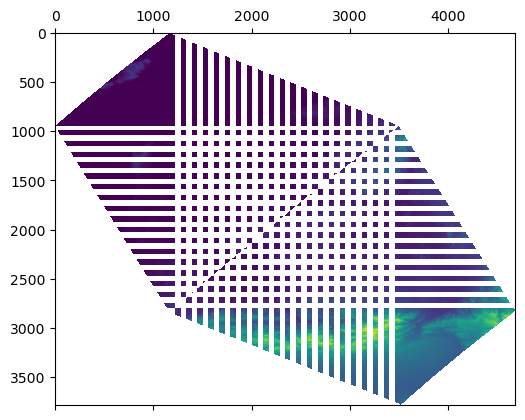

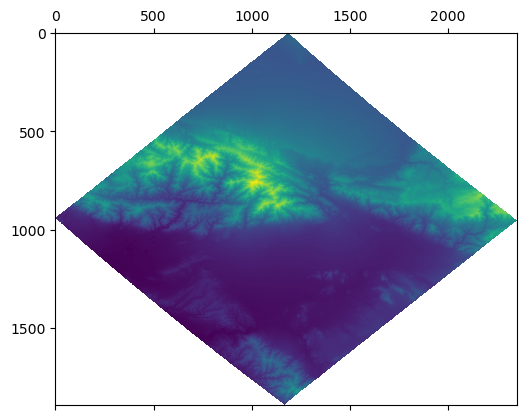

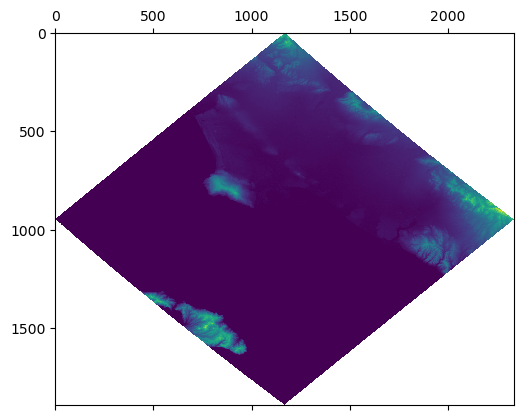

In [25]:
# for visualization

elev = np.empty((len(lat), len(lon))) + np.nan

for i in range(len(lat2)):
    for j in range(len(lon2)):
        elev[lat_order[i], lon_order[j]] = elev2[i, j]

for i in range(len(lat3)):
    for j in range(len(lon3)):
        elev[
            lat_order[len(lat2) + i],
            lon_order[len(lon2) + j]
        ] = elev3[i, j]

plt.show(plt.matshow(elev))
plt.matshow(elev3)
plt.matshow(elev2)

# Combining ECOSTRESS datasets

In [30]:
eco_slt = rioxarray.open_rasterio(eco_slt_path)
eco_slu = rioxarray.open_rasterio(eco_slu_path)
eco_smt = rioxarray.open_rasterio(eco_smt_path)

In [22]:
eco_slt_xr = eco_slt.to_dataset('band').rename({1:'LSTE'})
eco_slu_xr = eco_slu.to_dataset('band').rename({1:'LSTE'})
eco_smt_xr = eco_smt.to_dataset('band').rename({1:'LSTE'})
eco_df = pd.concat(
    [
    eco_slt_xr.to_dataframe(),
    eco_slu_xr.to_dataframe(),
    eco_smt_xr.to_dataframe(),
    ]
)

In [23]:
eco_unique = eco_df.reset_index().drop_duplicates(subset=['y', 'x'])
eco = eco_unique.set_index(['y', 'x']).to_xarray()
eco = eco.assign_attrs(eco_slt.attrs)
eco = eco.reset_coords('spatial_ref', drop=True)
eco = eco.assign_coords({'spatial_ref':eco_slt_xr.variables['spatial_ref']})

In [30]:
eco.to_netcdf(eco_clean_path)

# Aligning EMIT and ECOSTRESS data

In [3]:
# load emit
emit = xr.open_dataset(emit_clean_path)
emit = emit.reset_coords('elev')


# load ecostress
eco = xr.open_dataset(eco_clean_path)

In [12]:
# get the coordinate systems
old_cs = osr.SpatialReference()
old_cs.ImportFromWkt(emit['spatial_ref'].attrs['crs_wkt'])

new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(eco['spatial_ref'].attrs['crs_wkt'])

transform = osr.CoordinateTransformation(old_cs, new_cs)

emit_lat = emit['latitude'].values
emit_lon = emit['longitude'].values

In [5]:
emit_y = np.empty(len(emit_lat)) + np.nan
emit_x = np.empty(len(emit_lon)) + np.nan

for y_ind, lat_val in enumerate(emit_lat):
    emit_y[y_ind] = transform.TransformPoint(
        lat_val,
        emit_lon[int(y_ind / 0.81)],
    )[1]
    
for x_ind, lon_val in enumerate(emit_lon):
    emit_x[x_ind] = transform.TransformPoint(
        emit_lat[int(x_ind * 0.8)],
        lon_val,
    )[0]

(
    (
        np.abs(np.argsort(emit_y) - np.arange(len(emit_y))).sum(),
        np.abs(np.argsort(emit_x) - np.arange(len(emit_x))).sum()
    ),
    (
        len(emit_y) - len(np.unique(emit_y)),
        len(emit_x) - len(np.unique(emit_x)),

    ),
)

((1180, 0), (0, 0))

In [5]:
# coords
wavelengths = emit.coords['wavelengths']
fwhm = emit.coords['fwhm']
spatial_ref = emit.coords['spatial_ref']

y = np.sort(emit_y)
x = np.sort(emit_x)

coords = {
    'wavelengths': wavelengths,
    'fwhm': fwhm,
    'spatial_ref': spatial_ref,
    'y': y,
    'x': x,
}

In [7]:
# variables
ref_old = emit['reflectance'].values
elev_old = emit['elev'].values

y_order = np.argsort(np.argsort(emit_y))
x_order = np.argsort(np.argsort(emit_x))

ref = np.empty_like(ref_old) + np.nan
elev = np.empty_like(elev_old) + np.nan

In [8]:
for i in range(len(y)):
    for j in range(len(x)):
        ref[y_order[i], x_order[j], :] = ref_old[i, j, :]
        elev[y_order[i], x_order[j]] = elev_old[i, j]

data_vars = {
    'reflectance':(('y', 'x', 'wavelengths'), ref),
    'elev':(('y', 'x'), elev),
}

In [9]:
emit_yx = xr.Dataset(data_vars, coords)
emit_yx = emit_yx.assign_attrs(emit.attrs)

In [10]:
emit_yx.to_netcdf(emit_yx_path)

In [3]:
emit_yx = xr.open_dataset(emit_yx_path)

eco = xr.open_dataset(eco_clean_path)

In [4]:
interp_eco = eco.interp_like(emit_yx, assume_sorted=True)

In [5]:
interp_eco.to_netcdf(eco_on_emit_path)

### Dataset 2 version

In [3]:
# load emit
emit = xr.open_dataset(emit_clean_2_path)
emit = emit.reset_coords('elev')

# load ecostress
eco_day = xr.open_dataset(eco_day_path)
eco_night = xr.open_dataset(eco_night_path)

In [4]:
temps = eco_day['band_data'][0, :, :].values
eco_day = eco_day.drop_vars('band_data')
eco_day = eco_day.assign_coords({
    'latitude': eco_day['y'].values,
    'longitude': eco_day['x'].values
})
eco_day = eco_day.drop_indexes(['band', 'x', 'y'])
eco_day = eco_day.reset_coords(['band', 'x', 'y'], drop=True)
eco_day = eco_day.assign(
    {'temp': (('latitude', 'longitude'), temps)}
)

temps = eco_night['band_data'][0, :, :].values
eco_night = eco_night.drop_vars('band_data')
eco_night = eco_night.assign_coords({
    'latitude': eco_night['y'].values,
    'longitude': eco_night['x'].values
})
eco_night = eco_night.drop_indexes(['band', 'x', 'y'])
eco_night = eco_night.reset_coords(['band', 'x', 'y'], drop=True)
eco_night = eco_night.assign(
    {'temp': (('latitude', 'longitude'), temps)}
)

In [5]:
interp_eco_day = eco_day.interp_like(emit)
interp_eco_night = eco_night.interp_like(emit)

In [9]:
interp_eco_day.to_netcdf(eco_day_on_emit_path)
interp_eco_night.to_netcdf(eco_night_on_emit_path)

# Processing data

In [6]:
emit_yx = xr.open_dataset(emit_yx_path)
eco_on_emit = xr.open_dataset(eco_on_emit_path)

In [7]:
data_yx = emit_yx.assign({'LSTE': eco_on_emit['LSTE']})

In [8]:
lste = data_yx['LSTE'].values
ref_sum = data_yx['reflectance'].values.sum(axis=2)
elev = data_yx['elev'].values

In [9]:
nan_mask = np.isnan(lste) + np.isnan(ref_sum) + np.isnan(elev)
nan_mask = ~nan_mask.astype(bool)
data_yx = data_yx.assign_coords({'good_coords': (('y', 'x'), nan_mask)})

In [16]:
data_yx.to_netcdf(data_yx_path)

In [17]:
data_yx = xr.open_dataset(data_yx_path)

In [42]:
good_coords = data_yx['good_coords'].values
y_filter = good_coords.sum(axis=1) > 0
x_filter = good_coords.sum(axis=0) > 0
good_coords = good_coords[y_filter, :]
good_coords = good_coords[:, x_filter]

y = data_yx['y'].values[y_filter]
x = data_yx['x'].values[x_filter]

ref = data_yx['reflectance'].values
ref = ref[y_filter, :, :]
ref = ref[:, x_filter, :]

elev = data_yx['elev'].values
elev = elev[y_filter, :]
elev = elev[:, x_filter]

lste = data_yx['LSTE'].values
lste = lste[y_filter, :]
lste = lste[:, x_filter]

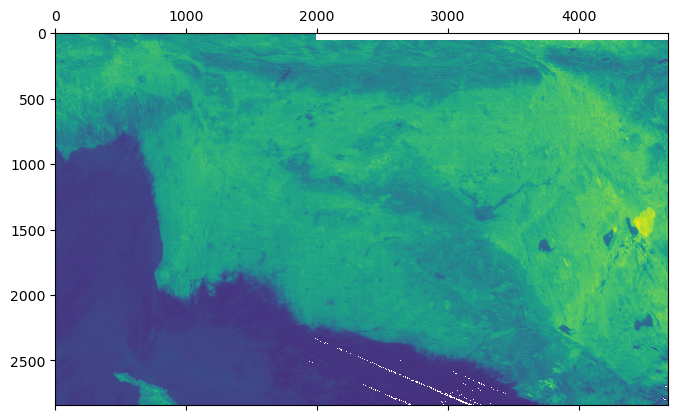

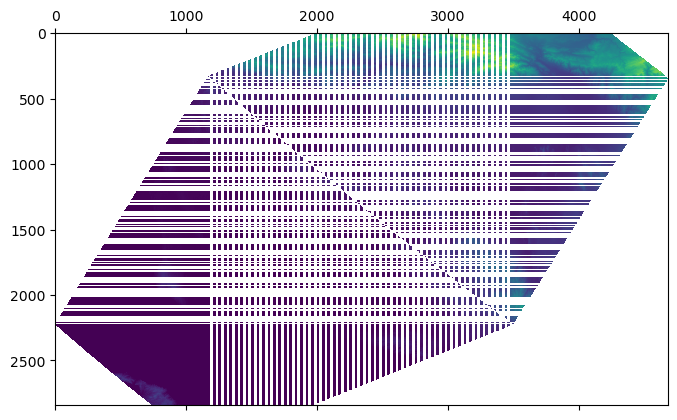

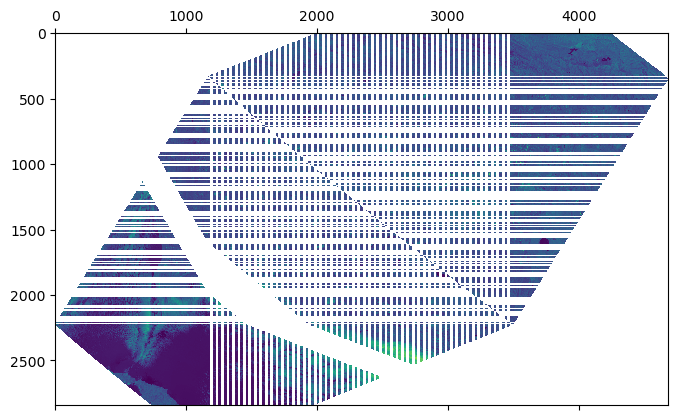

In [43]:
plt.matshow(lste[::-1, :])
plt.matshow(elev[::-1, :])
plt.matshow(ref[::-1, :, 100])

In [44]:
ref_good = ref[good_coords, :]
elev_good = elev[good_coords]
lste_good = lste[good_coords]

In [46]:
pickle_list = [
    ('good_coords', good_coords),
    ('y', y),
    ('x', x),
    ('reflectance', ref),
    ('reflectance_filtered', ref_good),
    ('elevation', elev),
    ('elevation_filtered', elev_good),
    ('LSTE', lste),
    ('LSTE_filtered', lste_good),
]

In [47]:
for filename, data in pickle_list:
    pickle.dump(data, open(decomposed_path.replace('(__)', filename), 'wb'))

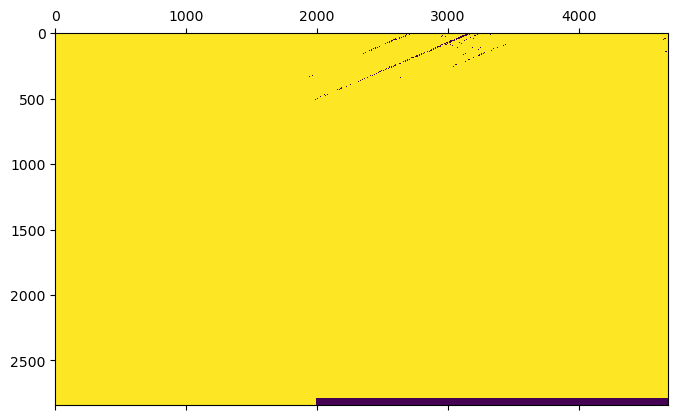

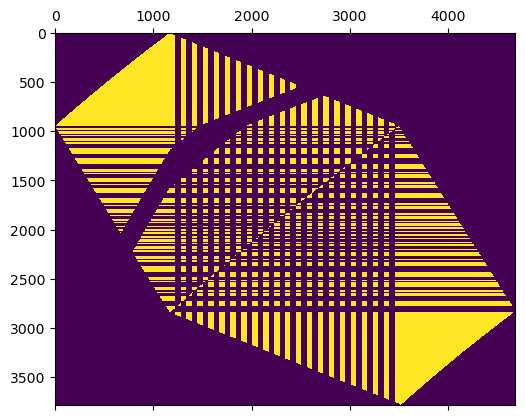

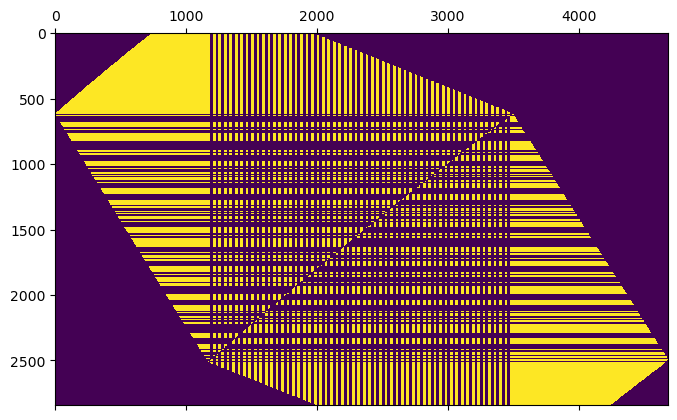

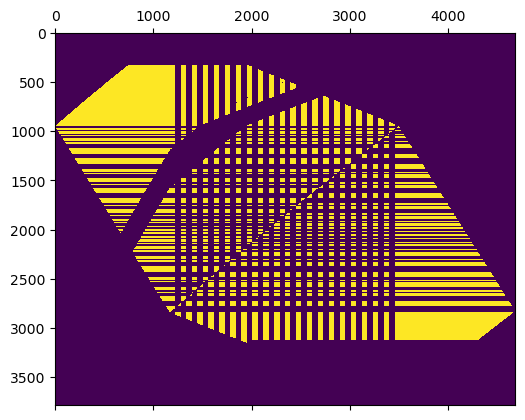

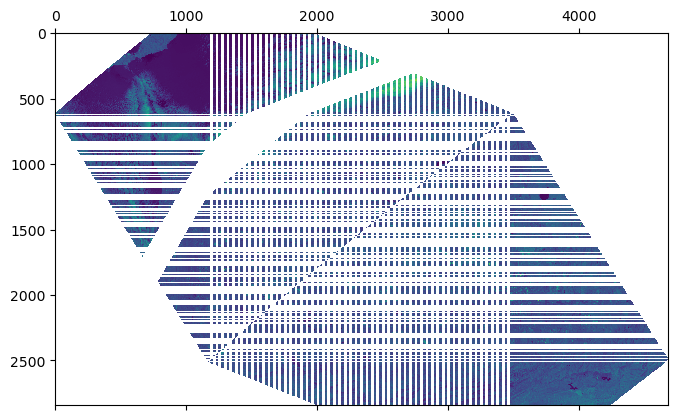

In [48]:
# for visualization
plt.matshow(~np.isnan(lste))
plt.matshow(~np.isnan(ref_sum))
plt.matshow(~np.isnan(elev))
plt.matshow(nan_mask)
plt.matshow(ref[:,:,100])

### Dataset 2 version

In [3]:
emit = xr.open_dataset(emit_clean_2_path)
emit = emit.reset_coords('elev')

eco_day_on_emit = xr.open_dataset(eco_day_on_emit_path)
eco_night_on_emit = xr.open_dataset(eco_night_on_emit_path)

In [4]:
data = emit.assign({'temp_day': eco_day_on_emit['temp']})
data = data.assign({'temp_night': eco_night_on_emit['temp']})

In [5]:
temp_day = eco_day_on_emit['temp'].values
temp_night = eco_night_on_emit['temp'].values
ref_sum = data['reflectance'].values.sum(axis=2)
elev = data['elev'].values

In [13]:
nan_mask = (
    np.isnan(temp_day) + np.isnan(temp_night) +
    np.isnan(ref_sum) + np.isnan(elev)
)
nan_mask = ~nan_mask.astype(bool)
data = data.assign_coords(
    {'good_coords': (('latitude', 'longitude'), nan_mask)}
)

In [14]:
data.to_netcdf(data_2_path)

In [3]:
data = xr.open_dataset(data_2_path)

In [4]:
good_coords = data['good_coords'].values.astype(float)
lat_filter = good_coords.sum(axis=1) > 0
lon_filter = good_coords.sum(axis=0) > 0
good_coords = good_coords[lat_filter, :]
good_coords = good_coords[:, lon_filter]
good_coords[good_coords == 0] = np.nan

lat = data['latitude'].values[lat_filter]
lon = data['longitude'].values[lon_filter]

ref = data['reflectance'].values
ref = ref[lat_filter, :, :]
ref = ref[:, lon_filter, :]
ref = ref * good_coords[:, :, np.newaxis].repeat(ref.shape[2], 2)

elev = data['elev'].values
elev = elev[lat_filter, :]
elev = elev[:, lon_filter]
elev = elev * good_coords

temp_day = data['temp_day'].values
temp_day = temp_day[lat_filter, :]
temp_day = temp_day[:, lon_filter]
temp_day = temp_day * good_coords

temp_night = data['temp_night'].values
temp_night = temp_night[lat_filter, :]
temp_night = temp_night[:, lon_filter]
temp_night = temp_night * good_coords

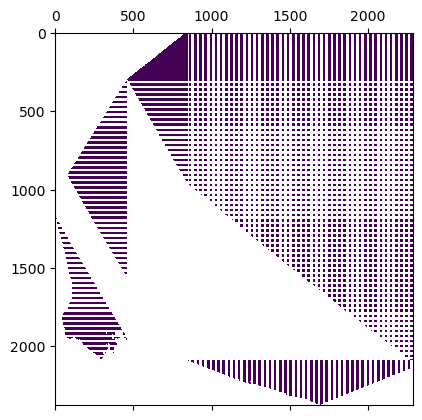

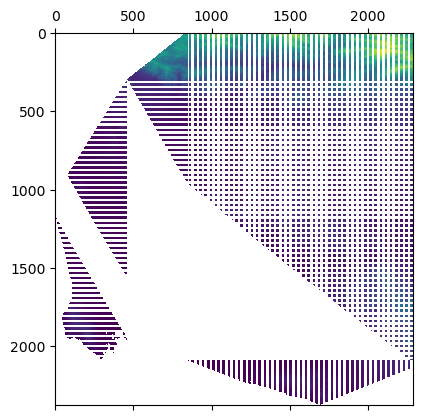

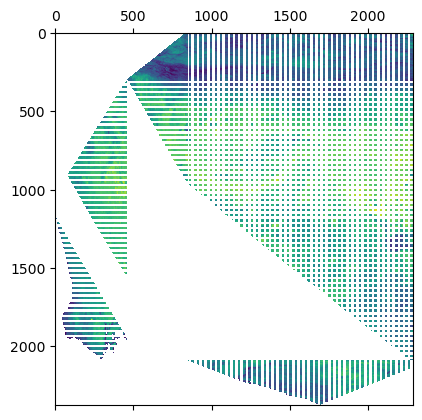

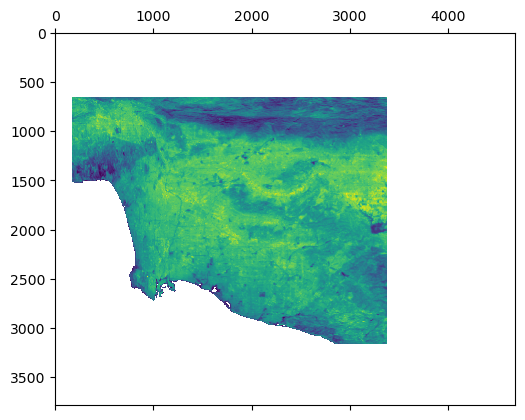

In [8]:
plt.matshow(good_coords[::-1,:])
plt.matshow(elev[::-1,:])
plt.matshow(temp_day[::-1,:])
plt.matshow(data['temp_day'][::-1])

In [11]:
ref_list = ref[~np.isnan(ref)]
elev_list = elev[~np.isnan(elev)]
temp_day_list = temp_day[~np.isnan(temp_day)]
temp_night_list = temp_night[~np.isnan(temp_night)]

In [ ]:
pickle_list = [
    ('good_coords', good_coords),
    ('latitude', lat),
    ('longitude', lon),
    ('reflectance', ref),
    ('reflectance_list', ref_list),
    ('elevation', elev),
    ('elevation_list', elev_list),
    ('temp_day', temp_day),
    ('temp_day_list', temp_day_list),
    ('temp_night', temp_night),
    ('temp_night_list', temp_night_list),
]

In [ ]:
for filename, data in pickle_list:
    pickle.dump(data, open(decomposed_2_path.replace('(__)', filename), 'wb'))